###  This jupyter file is using for analysis so, all needed methods from BCI interface, No one should write any function existing in BCI interface, if you need new feature write it in BCI interface for relavinte topic then import and use it, this file is using for logic and analysis **ONLY**.

### Import All Needed Class

In [49]:
from BCInterface.Helpers import helper
from BCInterface.Visualization.Visualization import graphs
from BCInterface.Preprocessing.DataPrepare import DataPrepare
from BCInterface.Preprocessing.files_manager import Filesmanager
from mainproccess import Process

import os
import glob

In [50]:
dirc = os.path.abspath("../"+'EEG-SSVEP-DataSet')
dirc

'C:\\Users\\compuland\\Documents\\GitHub\\EEG-SSVEP-DataSet'

### Some users configuations and files, trails, etc...

In [51]:
number_sec = 5           # sellect example time
path_dir_= dirc + '\\5_S\\'
File_regexp= 'U0000*.csv' # [p|q|r|s|t] [a|b|c|d|e|f|g|h|i|j]


'C:\\Users\\compuland\\Documents\\GitHub\\EEG-SSVEP-DataSet\\5_S\\'

### Get Data from files, and prepare it.

In [52]:
prepare = DataPrepare()
data = prepare.get_dataFromFiles(glob.glob(path_dir_ + File_regexp),concate=True)
trials_list = prepare.Extraxt_trials(data, number_sec)     # divid the data to list of data to anla.
Labels = data['Label'] #.drop('Label',axis=1)
Labels[640*2]

1.0

# Trial Numbers

In [53]:
Trial_number = 1

### Time Domain Visualization, before CAR

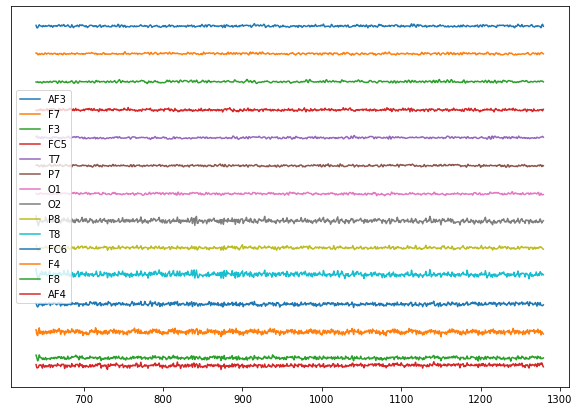

In [54]:
graphs.time_vis(trials_list[Trial_number])

### Calcualte CAR 

In [55]:
data_car = helper.CAR(data.copy())
trials_list_after_CAR = prepare.Extraxt_trials(data_car, number_sec)
# freq, power , label = helper.welch(trials_list_after_CAR[Trial_number].copy(),True, True)

### Time Domain Visualization, after CAR

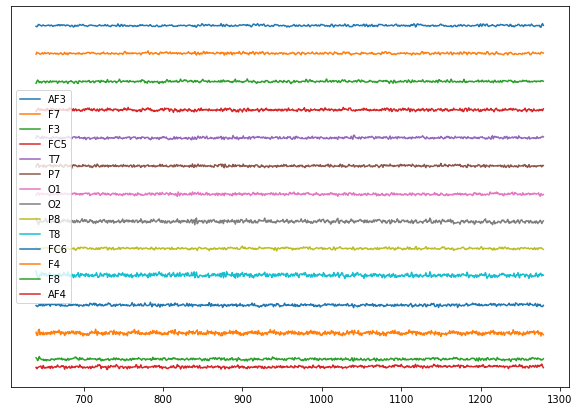

In [56]:
graphs.time_vis(trials_list_after_CAR[Trial_number])

### BandPass filter with freq response.

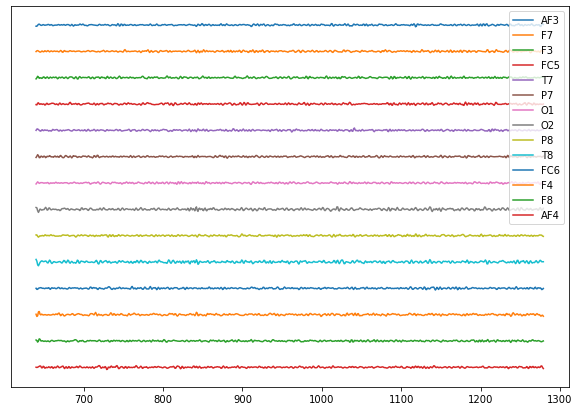

In [57]:
data_filter = helper.butter_band_filter(data_car.copy(),5, 40)
trials_list_after_filter = prepare.Extraxt_trials(data_filter, number_sec)
graphs.time_vis(trials_list_after_filter[Trial_number])

### Power using welch.

In [58]:
freq, power, label = helper.welch(trials_list_after_filter[Trial_number].copy(),True, True)
print(label)
# label= Labels[Trial_number*128*5]
# label

8.57


### Power vs. Frequency visualization

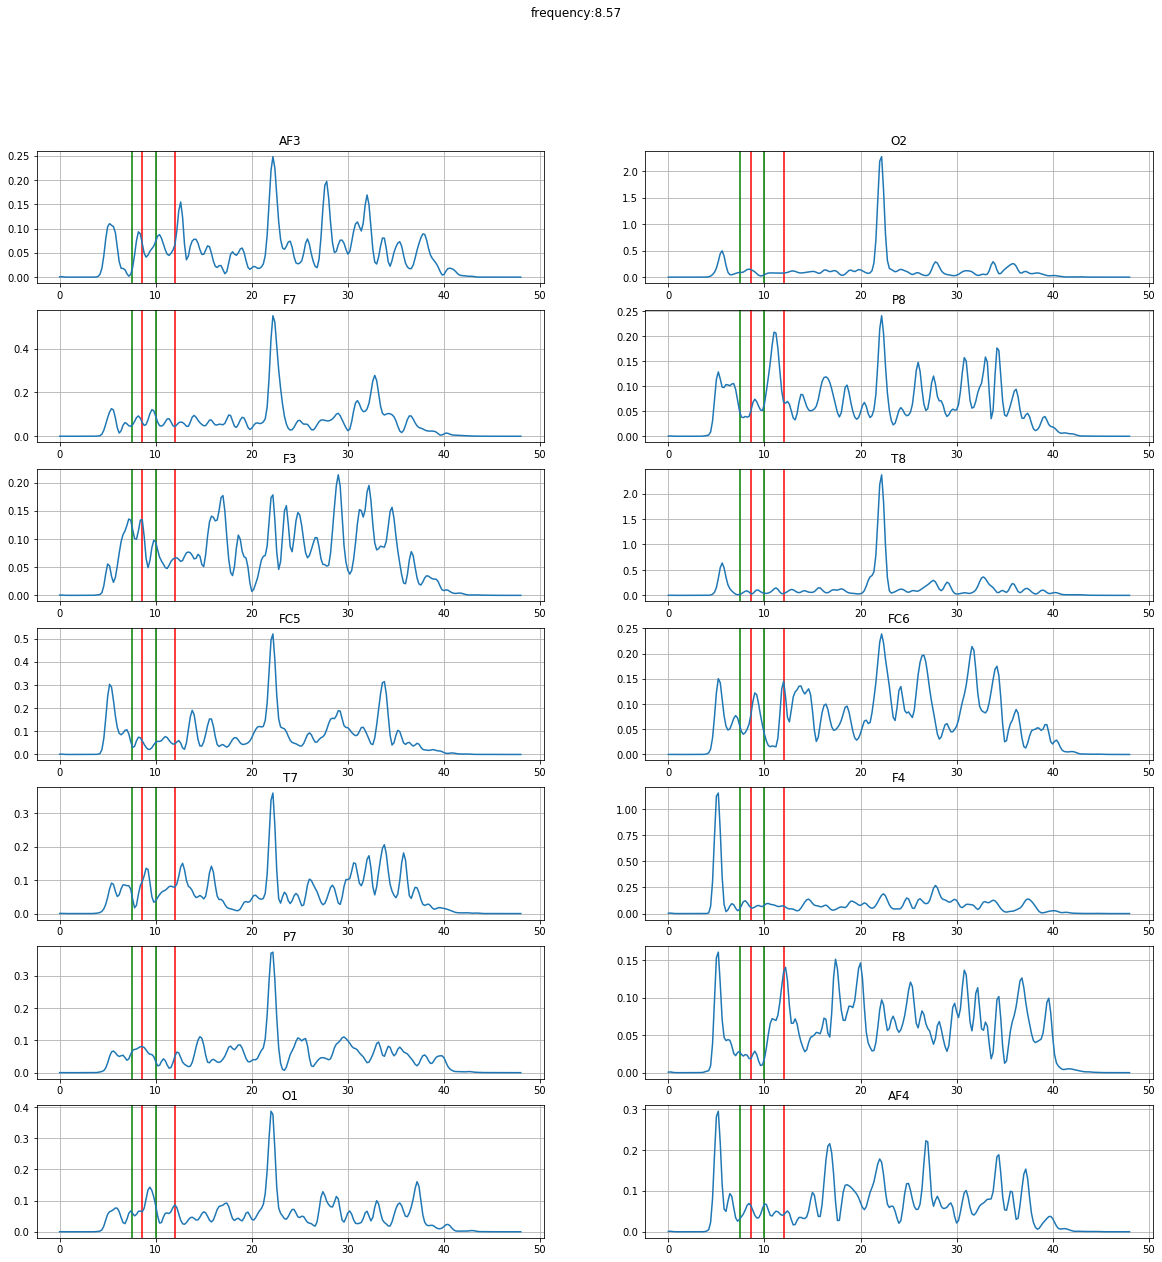

In [59]:
graphs.welch_vis(freq, power,label,[0,1,2,3,4,5,6,7,8,9,10,11,12,13])

### Extract Features 

In [60]:
freq = helper.welch_file(data_filter, 5)
(Features ,Labels) = helper.featureExtraction_welch(freq, 3,['P7', 'O1', 'O2', 'P8']) #['P7', 'O1', 'O2', 'P8', 'T8', 'AF4']

### select tunable parameters

In [61]:
# train_size = .7
# Num_compunant = 35
# Normalizer_type = 'l1'
# # Model
# Kernel = "poly"
# Degree = 3
# Gamma = .6
# c = 25


train_size = .6
Num_compunant = 15
Normalizer_type = 'l1'
# Model
Kernel = "poly"
Degree = 2
Gamma = .5
c = 2

### prepare labels and splite

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import pandas as pd
lab_enc = LabelEncoder()
encoded = lab_enc.fit_transform(Labels)
# x_train, x_test, y_train, y_test = train_test_split(Features, encoded, random_state=0, train_size=train_size)
x_train, x_test, y_train, y_test = Features[0:58] , Features[58:], encoded[0:58], encoded[58:]

### apply PCA and train the model (Manually)

In [66]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn

pca = PCA(n_components=Num_compunant)
pca.fit(x_train)

x_train = pd.DataFrame(pca.transform(x_train))
x_test  = pd.DataFrame(pca.transform(x_test))


model = Pipeline([
    ("scaler", sklearn.preprocessing.Normalizer(norm = Normalizer_type)),
    ("svm_clf", sklearn.svm.SVC(kernel=Kernel, degree=Degree, coef0=1, gamma= Gamma, C=c,probability=False))
])

model.fit(x_train, y_train)

print(model.decision_function(x_train[:3]))
print(model.predict(x_train[:3]))

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))
print('traing shape=', x_train.shape)
print('testing shape=', x_test.shape)

[[-0.26529855  1.89036168  0.80984394  4.26616142  3.21235452]
 [-0.26531631  1.89180506  0.81460677  4.26503595  3.21229077]
 [-0.26535459  1.89131926  0.81080977  4.26565881  3.21318058]]
[3 3 3]
0.6724137931034483
0.7422680412371134
traing shape= (58, 15)
testing shape= (97, 15)


In [67]:
import numpy as np
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(data, model, thres=0.96):
    probs = sigmoid(model.decision_function(data))
    print(probs)
    preds = np.argmax(probs, axis=1) + 1
    is_null = (probs < thres).all(axis=1)
    
    preds = np.where(is_null, 0, preds)
    return preds
    

preds = predict(x_train[:15], model)
freq = {7.5:1,8.57:2,10.0:3,12.0:4}
print(Labels)
print(model.predict(x_train[:15]))
print(preds)

[[0.43406166 0.86879676 0.69207625 0.98615871 0.96129656]
 [0.43405729 0.86896121 0.69309031 0.98614334 0.96129419]
 [0.43404789 0.86890588 0.69228203 0.98615185 0.96132728]
 [0.43405335 0.8693797  0.69275202 0.98613794 0.96134257]
 [0.43405873 0.86921792 0.69248022 0.98615183 0.96126886]
 [0.43405134 0.86943243 0.69179777 0.98616179 0.96124938]
 [0.43405398 0.88077777 0.69151242 0.986135   0.96070394]
 [0.43406651 0.87057361 0.69173392 0.98614359 0.96130941]
 [0.43402742 0.88707142 0.69796026 0.9860503  0.96013189]
 [0.43406946 0.88224324 0.69389214 0.9861047  0.96054491]
 [0.43398718 0.89543872 0.69488699 0.98603154 0.95921227]
 [0.43384303 0.8742962  0.694367   0.9861575  0.96061498]
 [0.43406966 0.86933163 0.69190441 0.98616028 0.96124979]
 [0.43405595 0.86942255 0.69291438 0.98614228 0.96128169]
 [0.43406307 0.86916275 0.69217385 0.98614948 0.9613298 ]]
[7.5, 8.57, 1.0, 10.0, 12.0, 10.0, 10.0, 7.5, 8.57, 1.0, 10.0, 12.0, 10.0, 7.5, 12.0, 1.0, 8.57, 10.0, 8.57, 12.0, 7.5, 8.57, 10.

In [71]:
p = np.array(model.decision_function(x_train[:15]))  # decision is a voting function
prob = np.exp(p) / np.sum(np.exp(p), axis=1, keepdims=True)  # softmax after the voting
print(prob)

[[0.0072547  0.06263408 0.02125924 0.67391852 0.23493346]
 [0.00725879 0.06276102 0.02137316 0.67355194 0.23505509]
 [0.00725476 0.06269812 0.02128115 0.67362323 0.23514274]
 [0.00725695 0.0629775  0.02133415 0.67312607 0.23530532]
 [0.00725637 0.06288146 0.02130475 0.67374191 0.23481551]
 [0.00725311 0.06297389 0.02122772 0.67395101 0.23459427]
 [0.00723758 0.0697162  0.02115373 0.67118315 0.23070934]
 [0.00725273 0.06360531 0.02121896 0.6729767  0.2349463 ]
 [0.00725504 0.07431436 0.02186174 0.66873238 0.22783649]
 [0.00724694 0.07078822 0.02141786 0.67052302 0.23002397]
 [0.00725294 0.08100806 0.02154352 0.66773723 0.22245825]
 [0.00725486 0.06584811 0.02150908 0.67447338 0.23091457]
 [0.0072545  0.06292537 0.02124082 0.67395506 0.23462425]
 [0.00725798 0.0630095  0.02135322 0.67342811 0.23495119]
 [0.00725499 0.06283788 0.02126971 0.67348589 0.23515154]]


# Confusion Matrix

Confusion matrix, without normalization
[[17  0  0  1]
 [ 0 17  0  0]
 [ 0  0 34  0]
 [ 0  2 22  4]]
Normalized confusion matrix
[[0.94444444 0.         0.         0.05555556]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.07142857 0.78571429 0.14285714]]


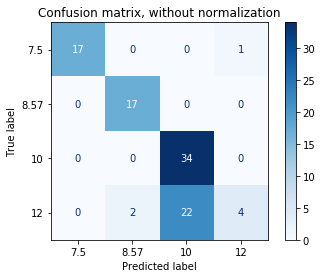

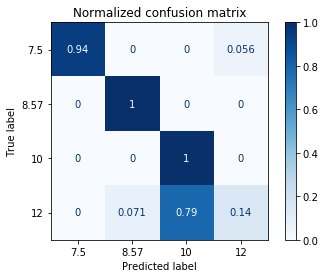

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ["7.5","8.57","10","12",'1']
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Save & Load (Model & PCA)

In [29]:
# load Model
import pickle
Model_filename = 'Finalized_Model_model.sav'
PCA_filename   = 'Finalized_PCA_model.sav'

# pickle.dump(model, open(Model_filename, 'wb'))
# pickle.dump(pca, open(PCA_filename, 'wb'))

In [30]:
loaded_Pca   = pickle.load(open(PCA_filename, 'rb'))
loaded_model = pickle.load(open(Model_filename, 'rb'))

In [31]:
x_train = pd.DataFrame(loaded_Pca.transform(x_train))
x_test  = pd.DataFrame(loaded_Pca.transform(x_test))


loaded_model.fit(x_train, y_train)

print(loaded_model.score(x_train, y_train))
print(loaded_model.score(x_test, y_test))
print('traing shape=', x_train.shape)
print('testing shape=', x_test.shape)

0.9655172413793104
1.0
traing shape= (58, 15)
testing shape= (26, 15)


# Tune models

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB

models = [
    OneVsRestClassifier(LogisticRegression()),
    OneVsRestClassifier(SVC()),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

for model in models:
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    valid_score = model.score(x_test, y_test)
    print(f"Class {model.__class__.__name__}:")
    print(f"    train: {train_score}\n    valid: {valid_score}\n")



In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{
    'max_depth': [50,80],
    'max_features': [2, 3,5],
    'min_samples_leaf': [2, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}]


model = RandomForestClassifier()

grid_search = GridSearchCV(model, param_grid, cv=5,return_train_score = True)

grid_search.fit(x_train, y_train)

print(grid_search.score(x_train, y_train))
print(grid_search.score(x_test, y_test))
print(grid_search.best_params_)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{
    "max_depth": [1,5, 10, 20, 30, 40, 50],
    "min_samples_leaf": [1, 2, 3, 5,10,20,30,40],
    "max_leaf_nodes": [2,10, 20, 30, 40, 50, 60]
}]

model = DecisionTreeClassifier()
grid_search = GridSearchCV(
    model, param_grid, cv=5,
#     scoring = "neg_mean_squared_error",
    return_train_score = True
)

grid_search.fit(x_train, y_train)

print(grid_search.score(x_train, y_train))
print(grid_search.score(x_test, y_test))
print(grid_search.best_params_)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'C': [.001,.002,.003,.01,.1,1,2,3,4,5,6,7,8 ,10, 100, 1000],
    'gamma': [1e-1,1e-2,1e-3, 1e-4],
    'kernel': ['poly'],
    'degree':[1,2,3]           
}]


model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score = True)

grid_search.fit(x_train, y_train)

print(grid_search.score(x_train, y_train))
print(grid_search.score(x_test, y_test))
print(grid_search.best_params_)

### save module

In [13]:
import pickle
Model_filename = 'Finalized_Model_model.sav'
PCA_filename   = 'Finalized_PCA_model.sav'

# pickle.dump(grid_search, open(Model_filename, 'wb'))
# pickle.dump(pca, open(PCA_filename, 'wb'))

In [14]:
# Data.drop(['Label'], axis='columns', inplace=True)
Run_time = Process()
Run_time.make_process(data[0:640])

[[0.02190923 0.06123157 0.2150118  0.70184739]]
12.0


C:\Users\compuland\Documents\GitHub\BCI_interface\BCInterface\Helpers\Helpers.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data[i] = Data[i] - mean
C:\Users\compuland\Documents\GitHub\BCI_interface\BCInterface\Helpers\Helpers.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ch] = butter_lowpass_filter(df[ch].values, highcut, fs=FS, order=Order)
C:\Users\compuland\Documents\GitHub\BCI_interface\BCInterface\Helpers\Helpers.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [15]:
loaded_Pca = pickle.load(open(PCA_filename, 'rb'))

loaded_model = pickle.load(open(Model_filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

NameError: name 'x_test' is not defined

## testing 

In [ ]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

grid = GridSearchCV(, param_grid={'C': [1, 10]},
                   scoring=ftwo_scorer, cv=5)

In [ ]:
prepare = DataPrepare()
data = prepare.get_dataFromFiles(glob.glob(path_dir_ + File_regexp),concate=True)
# Todo
# 1- 
# 2- 
trials_list = prepare.Extraxt_trials(data, number_sec)     # divid the data to list of data to anla.
Labels = data['Label'] #.drop('Label',axis=1)
trials_list[0]

# End ---------------------------------------------------

In [ ]:
# user2  = model.predict(x_test.iloc[0])
examlpe = [0]
print('prediction' , lab_enc.inverse_transform(model.predict(x_test.iloc[examlpe].values.reshape(1,-1))))
print ('true label' , lab_enc.inverse_transform(y_test[examlpe]))
print( lab_enc.inverse_transform([0, 1, 2, 3 , 4]))

In [ ]:
lab_enc.inverse_transform([0, 1, 2, 3])

### Prepare data for train

In [ ]:
prepare =  DataPrepare()
data = prepare.get_dataFromFiles(['D:/Graduation Project/EEG-SSVEP-DataSet/5_S/U0000ai.csv'], concate=True)


### Train

In [ ]:
process = Process()
process.train(data)

### Predict

### All needed modules can import or use it as you want.